# GAM (Generalized Additive Model)

Check library **pygam**. Furthermore, it is included a data cleaning based on a local regression technique.

In [7]:
%matplotlib inline
import sys
sys.path.append('../../')
from datasets import solar
import pandas as pd
import numpy as np

from pygam import LinearGAM, s, f

### load data

In [8]:
# load
data, dcol = solar.load()
# rename columns
data.rename(columns = {'DSWRF267':'s1', 'y':'s2'}, inplace=True)
# filter columns
data = data[['hour', 'doy', 'year', 's1', 's2']]

Load data..


### modelling per hour

In [328]:
ihour = 11
# filter rows
df = data[data.hour == ihour][['doy', 'year', 'hour','s1','s2']]

#### gam for DSWRF267

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


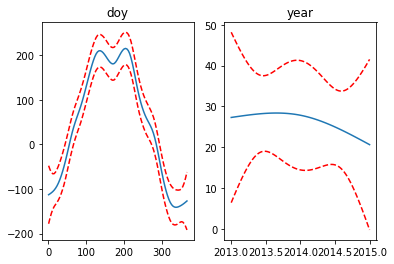

In [333]:
X = df[['doy', 'year']].values
y = df.s1.values
gam = LinearGAM(s(0)+s(1)).gridsearch(X, y)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
titles = ['doy', 'year']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i])

In [334]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9187
Link Function:                     IdentityLink Log Likelihood:                                -12649.4858
Number of Samples:                         1085 AIC:                                            25326.8089
                                                AICc:                                            25327.197
                                                GCV:                                            47155.4338
                                                Scale:                                          46145.8839
                                                Pseudo R-Squared:                                   0.2658
Feature Function                  Lam

#### gam for y

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


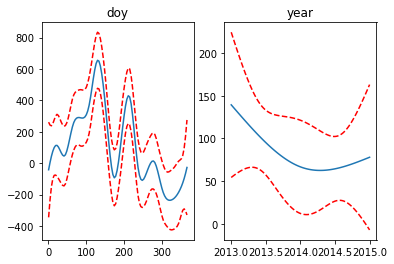

In [335]:
X = df[['doy', 'year']].values
y = df.s2.values
gam = LinearGAM(s(0)+s(1)).gridsearch(X, y)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
titles = ['doy', 'year']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i])

## MODELIZATION WITH GAM ( doy vs solar signal)

#### Locally Weighted Scatterplot Smoothing

In [322]:
def LOWESS(x:'array',y:'array',fraction:float=.2, isplot:bool = False):
    """
    LOWESS (Locally Weighted Scatterplot Smoothing)
    x -- x data.
    y -- y data.
    fraction -- between 0 and 1. The fraction of the data used when estimating each y-value (default 0.2). 
    """

    from scipy.interpolate import interp1d
    import statsmodels.api as sm
    # local regression
    lowess = sm.nonparametric.lowess(y, x, frac=.2, missing = 'drop')
    # unpack the lowess smoothed points to their values
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]
    # interpolation the different portions
    f = interp1d(lowess_x, lowess_y, bounds_error=False)
    xnew = sorted(list(set(x)))
    ynew = f(xnew)
    # plot
    if isplot:
        import matplotlib.pyplot as plt
        plt.plot(x, y, 'o')
        plt.plot(lowess_x, lowess_y, '*')
        plt.plot(xnew, ynew, '-')
        plt.title('Locally Weighted Scatterplot Smoothing')
        plt.show()
    # return
    return (xnew, ynew)


### Filtering + GAM Model

In [336]:
## arguments
svar = 's2'
ihour = 16
isplot = True
quartile = .5
df = data[data.hour == ihour][['doy', svar]]
x = df['doy'].values
y = df[svar].values

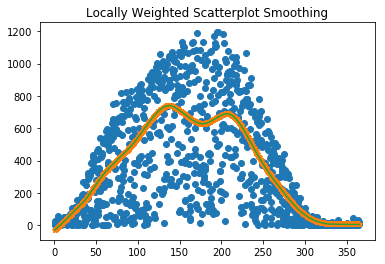

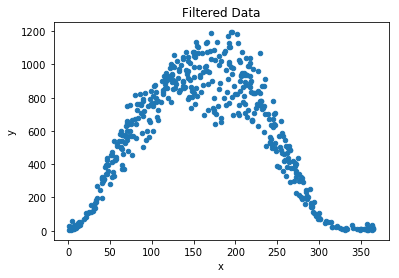

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


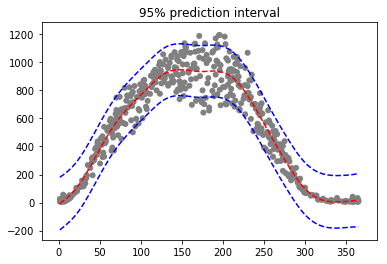

In [326]:
## local smoothing
x_new, y_new = LOWESS(x,y,fraction=.2, isplot = isplot)
# filter
f_filter = lambda x: y_new[x-1]
df_filter = pd.DataFrame(np.c_[x,y],columns = ['x','y'])
df_filter['y_filtered'] = df_filter[['x','y']].apply(lambda x: np.nan if x[1]<f_filter(int(x[0])) else x[1], axis = 1)
df_filter = df_filter.dropna()
df_filter = df_filter[df_filter.y>0.]
if isplot:
    import matplotlib.pyplot as plt
    df_filter.plot(x='x', y='y',kind='scatter', title = 'Filtered Data')
    plt.show()
    
## gam model
from pygam import LinearGAM
# get filtered data
X_filtered = df_filter[['x']].values
y_filtered = df_filter['y'].values
# gam model
gam = LinearGAM(s(0)).gridsearch(X_filtered, y_filtered)
XX = gam.generate_X_grid(term=0)
y_hat_p50 = gam.predict(XX)
y_hat_p95 = gam.prediction_intervals(XX, width=.95)
y_hat = gam.prediction_intervals(XX, width=quartile)
if isplot:
    import matplotlib.pyplot as plt
    plt.plot(XX, y_hat_p50, 'r--')
    plt.plot(XX, y_hat_p95, color='b', ls='--')
    plt.scatter(X_filtered, y_filtered, facecolor='gray', edgecolors='none')
    plt.title('95% prediction interval')
    plt.show()
    
## normalizer
from scipy.interpolate import interp1d
normalizer = interp1d(XX.ravel(), y_hat[:,1].ravel(), bounds_error=False)

## calculate results
ccmodel = normalizer(df.doy.values)
norm_var = df[svar].values / ccmodel

### results

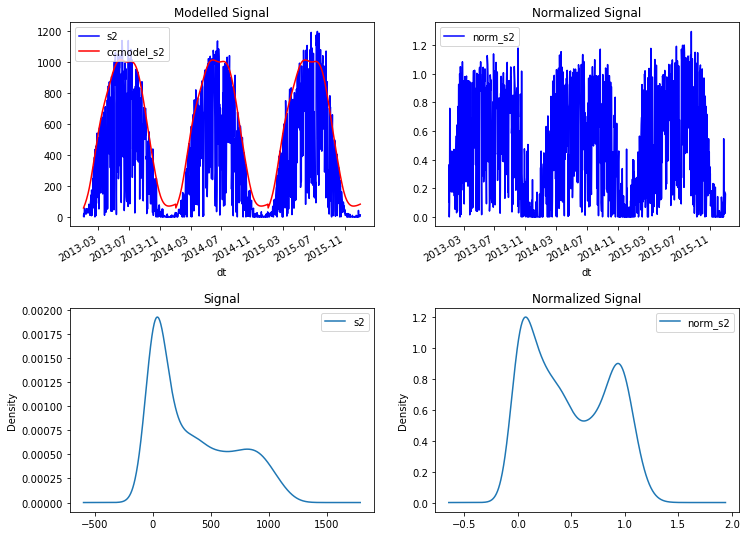

In [327]:
## plot results
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(12,10))

# add results
df['ccmodel_%s'%svar] = ccmodel
df['norm_%s'%svar] = norm_var

# plot cc model
ax1 = plt.subplot2grid((2,2),(0,0)) 
df[[svar]].plot(ax=ax1, color = 'blue')
df[['ccmodel_%s'%svar]].plot(ax=ax1, color = 'red', title = 'Modelled Signal')
# plot normalizer var
ax2 = plt.subplot2grid((2,2),(0,1)) 
df[['norm_%s'%svar]].plot(ax=ax2, color = 'blue', title = 'Normalized Signal')
# plot histogram of variable
ax3 = plt.subplot2grid((2,2),(1,0)) 
df[[svar]].plot(ax=ax3, kind = 'density', title = 'Signal')
# plot histogram of variable
ax4 = plt.subplot2grid((2,2),(1,1)) 
df[['norm_%s'%svar]].plot(ax=ax4, kind='density', title = 'Normalized Signal')
# show
plt.subplots_adjust(hspace = 0.4)
plt.show()